# Machine Learning Foundation

## Course 5, Part d: Keras Intro LAB

## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [1]:
#Setup
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
## Import Keras objects for Deep Learning
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

Using TensorFlow backend.


In [4]:
## Load in the data set 
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv('diabetes.csv', names=names, header=0)

In [5]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
471,0,137,70,38,0,33.2,0.170,22,0
452,0,91,68,32,210,39.9,0.381,25,0
209,7,184,84,33,0,35.5,0.355,41,1
498,7,195,70,33,145,25.1,0.163,55,1
626,0,125,68,0,0,24.7,0.206,21,0


In [6]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [7]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [8]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise 1: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [9]:
### BEGIN SOLUTION
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [10]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.771
roc-auc is 0.825


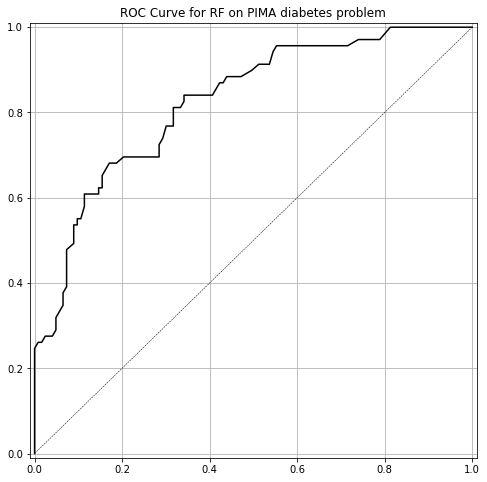

In [11]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')
### END SOLUTION

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [14]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [44]:
# Define a fully connected model 
# - Input size: 8-dimensional
# - Hidden layers: 2 layers, 12 hidden nodes/each, relu activation
# - Dense layers: we specify number of OUTPUT units; for the first layer we specify the input_shape, too
# - Activation: we can either add as layer Activation(...) or as parameter of Dense(activation=...)
# - Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential()
model_1.add(Dense(units=12, input_shape=(8,), activation='relu'))
model_1.add(Dense(units=12, input_shape=(8,), activation='relu'))
model_1.add(Dense(units=1, activation='sigmoid'))

In [45]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 12)                108       
_________________________________________________________________
dense_13 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 13        
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?

Let's fit our model for 200 epochs.

In [46]:
# Fit(Train) the Model

# Compile: Set the the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(optimizer=SGD(lr = .003),
                loss="binary_crossentropy", 
                metrics=["accuracy"])
# We pass the data to the fit() function,
# including the validation data
# The fit function returns the run history:
# it contains 'val_loss', 'val_accuracy', 'loss', 'accuracy'
run_hist_1 = model_1.fit(X_train_norm,
                         y_train,
                         validation_data=(X_test_norm, y_test),
                         epochs=200)


Train on 576 samples, validate on 192 samples
Epoch 1/200
576/576 [==============================] - 0s 565us/step - loss: 0.8116 - accuracy: 0.6528 - val_loss: 0.8837 - val_accuracy: 0.6458
Epoch 2/200
576/576 [==============================] - 0s 43us/step - loss: 0.7935 - accuracy: 0.6528 - val_loss: 0.8620 - val_accuracy: 0.6458
Epoch 3/200
576/576 [==============================] - 0s 44us/step - loss: 0.7774 - accuracy: 0.6493 - val_loss: 0.8428 - val_accuracy: 0.6406
Epoch 4/200
576/576 [==============================] - 0s 46us/step - loss: 0.7630 - accuracy: 0.6510 - val_loss: 0.8256 - val_accuracy: 0.6406
Epoch 5/200
576/576 [==============================] - 0s 57us/step - loss: 0.7502 - accuracy: 0.6493 - val_loss: 0.8103 - val_accuracy: 0.6406
Epoch 6/200
576/576 [==============================] - 0s 40us/step - loss: 0.7386 - accuracy: 0.6510 - val_loss: 0.7964 - val_accuracy: 0.6406
Epoch 7/200
576/576 [==============================] - 0s 40us/step - loss: 0.7284 - accu

576/576 [==============================] - 0s 37us/step - loss: 0.5636 - accuracy: 0.6910 - val_loss: 0.6034 - val_accuracy: 0.6875
Epoch 58/200
576/576 [==============================] - 0s 38us/step - loss: 0.5622 - accuracy: 0.6927 - val_loss: 0.6021 - val_accuracy: 0.6875
Epoch 59/200
576/576 [==============================] - 0s 37us/step - loss: 0.5607 - accuracy: 0.6927 - val_loss: 0.6008 - val_accuracy: 0.6875
Epoch 60/200
576/576 [==============================] - 0s 40us/step - loss: 0.5592 - accuracy: 0.6944 - val_loss: 0.5995 - val_accuracy: 0.6927
Epoch 61/200
576/576 [==============================] - 0s 48us/step - loss: 0.5577 - accuracy: 0.6944 - val_loss: 0.5982 - val_accuracy: 0.6979
Epoch 62/200
576/576 [==============================] - 0s 46us/step - loss: 0.5564 - accuracy: 0.6944 - val_loss: 0.5969 - val_accuracy: 0.6979
Epoch 63/200
576/576 [==============================] - 0s 37us/step - loss: 0.5549 - accuracy: 0.6944 - val_loss: 0.5957 - val_accuracy: 0.697

576/576 [==============================] - 0s 38us/step - loss: 0.5044 - accuracy: 0.7396 - val_loss: 0.5553 - val_accuracy: 0.7240
Epoch 114/200
576/576 [==============================] - 0s 37us/step - loss: 0.5037 - accuracy: 0.7396 - val_loss: 0.5547 - val_accuracy: 0.7240
Epoch 115/200
576/576 [==============================] - 0s 37us/step - loss: 0.5029 - accuracy: 0.7431 - val_loss: 0.5542 - val_accuracy: 0.7240
Epoch 116/200
576/576 [==============================] - 0s 37us/step - loss: 0.5021 - accuracy: 0.7413 - val_loss: 0.5537 - val_accuracy: 0.7240
Epoch 117/200
576/576 [==============================] - 0s 37us/step - loss: 0.5014 - accuracy: 0.7431 - val_loss: 0.5532 - val_accuracy: 0.7240
Epoch 118/200
576/576 [==============================] - 0s 37us/step - loss: 0.5006 - accuracy: 0.7413 - val_loss: 0.5527 - val_accuracy: 0.7240
Epoch 119/200
576/576 [==============================] - 0s 37us/step - loss: 0.4998 - accuracy: 0.7413 - val_loss: 0.5522 - val_accuracy:

576/576 [==============================] - 0s 38us/step - loss: 0.4699 - accuracy: 0.7674 - val_loss: 0.5356 - val_accuracy: 0.7396
Epoch 170/200
576/576 [==============================] - 0s 38us/step - loss: 0.4695 - accuracy: 0.7656 - val_loss: 0.5353 - val_accuracy: 0.7396
Epoch 171/200
576/576 [==============================] - 0s 38us/step - loss: 0.4690 - accuracy: 0.7691 - val_loss: 0.5351 - val_accuracy: 0.7500
Epoch 172/200
576/576 [==============================] - 0s 38us/step - loss: 0.4686 - accuracy: 0.7656 - val_loss: 0.5349 - val_accuracy: 0.7500
Epoch 173/200
576/576 [==============================] - 0s 40us/step - loss: 0.4682 - accuracy: 0.7674 - val_loss: 0.5347 - val_accuracy: 0.7552
Epoch 174/200
576/576 [==============================] - 0s 39us/step - loss: 0.4678 - accuracy: 0.7691 - val_loss: 0.5345 - val_accuracy: 0.7552
Epoch 175/200
576/576 [==============================] - 0s 38us/step - loss: 0.4673 - accuracy: 0.7656 - val_loss: 0.5344 - val_accuracy:

In [47]:
# Like we did for the Random Forest, we generate two kinds of predictions
# One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

In [48]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]], dtype=int32)

In [49]:
y_pred_prob_nn_1[:10]

array([[0.35208666],
       [0.62414396],
       [0.38794506],
       [0.3123997 ],
       [0.20048863],
       [0.37356794],
       [0.04133147],
       [0.34499168],
       [0.6365192 ],
       [0.19504961]], dtype=float32)

accuracy is 0.755
roc-auc is 0.798


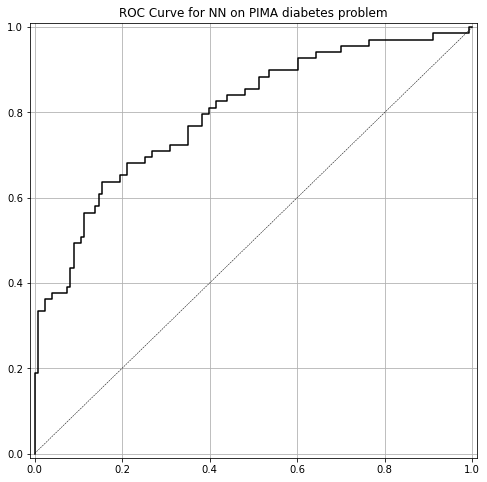

In [50]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [51]:
run_hist_1.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

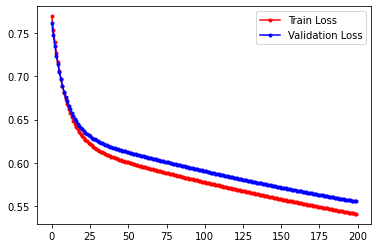

In [35]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [36]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Train on 576 samples, validate on 192 samples
Epoch 1/1000
576/576 [==============================] - 0s 76us/step - loss: 0.5407 - accuracy: 0.7153 - val_loss: 0.5551 - val_accuracy: 0.7240
Epoch 2/1000
576/576 [==============================] - 0s 46us/step - loss: 0.5404 - accuracy: 0.7153 - val_loss: 0.5548 - val_accuracy: 0.7240
Epoch 3/1000
576/576 [==============================] - 0s 36us/step - loss: 0.5401 - accuracy: 0.7153 - val_loss: 0.5545 - val_accuracy: 0.7240
Epoch 4/1000
576/576 [==============================] - 0s 35us/step - loss: 0.5397 - accuracy: 0.7153 - val_loss: 0.5542 - val_accuracy: 0.7240
Epoch 5/1000
576/576 [==============================] - 0s 35us/step - loss: 0.5394 - accuracy: 0.7153 - val_loss: 0.5539 - val_accuracy: 0.7240
Epoch 6/1000
576/576 [==============================] - 0s 35us/step - loss: 0.5391 - accuracy: 0.7135 - val_loss: 0.5536 - val_accuracy: 0.7240
Epoch 7/1000
576/576 [==============================] - 0s 39us/step - loss: 0.5388 

Epoch 57/1000
576/576 [==============================] - 0s 35us/step - loss: 0.5241 - accuracy: 0.7569 - val_loss: 0.5398 - val_accuracy: 0.7292
Epoch 58/1000
576/576 [==============================] - 0s 37us/step - loss: 0.5239 - accuracy: 0.7569 - val_loss: 0.5396 - val_accuracy: 0.7292
Epoch 59/1000
576/576 [==============================] - 0s 34us/step - loss: 0.5236 - accuracy: 0.7569 - val_loss: 0.5393 - val_accuracy: 0.7292
Epoch 60/1000
576/576 [==============================] - 0s 38us/step - loss: 0.5233 - accuracy: 0.7587 - val_loss: 0.5391 - val_accuracy: 0.7292
Epoch 61/1000
576/576 [==============================] - 0s 35us/step - loss: 0.5231 - accuracy: 0.7569 - val_loss: 0.5388 - val_accuracy: 0.7344
Epoch 62/1000
576/576 [==============================] - 0s 34us/step - loss: 0.5228 - accuracy: 0.7535 - val_loss: 0.5386 - val_accuracy: 0.7344
Epoch 63/1000
576/576 [==============================] - 0s 34us/step - loss: 0.5225 - accuracy: 0.7552 - val_loss: 0.5383 -

576/576 [==============================] - 0s 35us/step - loss: 0.5104 - accuracy: 0.7535 - val_loss: 0.5275 - val_accuracy: 0.7552
Epoch 114/1000
576/576 [==============================] - 0s 35us/step - loss: 0.5102 - accuracy: 0.7517 - val_loss: 0.5273 - val_accuracy: 0.7552
Epoch 115/1000
576/576 [==============================] - 0s 35us/step - loss: 0.5100 - accuracy: 0.7517 - val_loss: 0.5271 - val_accuracy: 0.7552
Epoch 116/1000
576/576 [==============================] - 0s 34us/step - loss: 0.5098 - accuracy: 0.7517 - val_loss: 0.5269 - val_accuracy: 0.7552
Epoch 117/1000
576/576 [==============================] - 0s 34us/step - loss: 0.5096 - accuracy: 0.7517 - val_loss: 0.5267 - val_accuracy: 0.7552
Epoch 118/1000
576/576 [==============================] - 0s 34us/step - loss: 0.5093 - accuracy: 0.7517 - val_loss: 0.5265 - val_accuracy: 0.7552
Epoch 119/1000
576/576 [==============================] - 0s 35us/step - loss: 0.5091 - accuracy: 0.7517 - val_loss: 0.5263 - val_acc

Epoch 169/1000
576/576 [==============================] - 0s 44us/step - loss: 0.4994 - accuracy: 0.7587 - val_loss: 0.5179 - val_accuracy: 0.7656
Epoch 170/1000
576/576 [==============================] - 0s 44us/step - loss: 0.4992 - accuracy: 0.7587 - val_loss: 0.5177 - val_accuracy: 0.7656
Epoch 171/1000
576/576 [==============================] - 0s 39us/step - loss: 0.4990 - accuracy: 0.7587 - val_loss: 0.5176 - val_accuracy: 0.7656
Epoch 172/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4988 - accuracy: 0.7587 - val_loss: 0.5174 - val_accuracy: 0.7656
Epoch 173/1000
576/576 [==============================] - 0s 48us/step - loss: 0.4986 - accuracy: 0.7587 - val_loss: 0.5173 - val_accuracy: 0.7708
Epoch 174/1000
576/576 [==============================] - 0s 48us/step - loss: 0.4985 - accuracy: 0.7587 - val_loss: 0.5171 - val_accuracy: 0.7656
Epoch 175/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4983 - accuracy: 0.7587 - val_loss: 0

Epoch 225/1000
576/576 [==============================] - 0s 94us/step - loss: 0.4905 - accuracy: 0.7622 - val_loss: 0.5105 - val_accuracy: 0.7656
Epoch 226/1000
576/576 [==============================] - 0s 64us/step - loss: 0.4904 - accuracy: 0.7639 - val_loss: 0.5104 - val_accuracy: 0.7656
Epoch 227/1000
576/576 [==============================] - 0s 64us/step - loss: 0.4902 - accuracy: 0.7622 - val_loss: 0.5103 - val_accuracy: 0.7656
Epoch 228/1000
576/576 [==============================] - 0s 55us/step - loss: 0.4901 - accuracy: 0.7604 - val_loss: 0.5101 - val_accuracy: 0.7656
Epoch 229/1000
576/576 [==============================] - 0s 69us/step - loss: 0.4899 - accuracy: 0.7622 - val_loss: 0.5100 - val_accuracy: 0.7656
Epoch 230/1000
576/576 [==============================] - 0s 60us/step - loss: 0.4898 - accuracy: 0.7622 - val_loss: 0.5099 - val_accuracy: 0.7656
Epoch 231/1000
576/576 [==============================] - 0s 55us/step - loss: 0.4896 - accuracy: 0.7622 - val_loss: 0

576/576 [==============================] - 0s 85us/step - loss: 0.4836 - accuracy: 0.7622 - val_loss: 0.5050 - val_accuracy: 0.7500
Epoch 281/1000
576/576 [==============================] - 0s 45us/step - loss: 0.4835 - accuracy: 0.7622 - val_loss: 0.5049 - val_accuracy: 0.7500
Epoch 282/1000
576/576 [==============================] - 0s 48us/step - loss: 0.4834 - accuracy: 0.7622 - val_loss: 0.5048 - val_accuracy: 0.7500
Epoch 283/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4833 - accuracy: 0.7622 - val_loss: 0.5047 - val_accuracy: 0.7500
Epoch 284/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4831 - accuracy: 0.7622 - val_loss: 0.5046 - val_accuracy: 0.7500
Epoch 285/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4830 - accuracy: 0.7622 - val_loss: 0.5045 - val_accuracy: 0.7500
Epoch 286/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4829 - accuracy: 0.7622 - val_loss: 0.5045 - val_acc

Epoch 336/1000
576/576 [==============================] - 0s 74us/step - loss: 0.4780 - accuracy: 0.7656 - val_loss: 0.5007 - val_accuracy: 0.7396
Epoch 337/1000
576/576 [==============================] - 0s 62us/step - loss: 0.4779 - accuracy: 0.7656 - val_loss: 0.5007 - val_accuracy: 0.7396
Epoch 338/1000
576/576 [==============================] - 0s 80us/step - loss: 0.4778 - accuracy: 0.7656 - val_loss: 0.5006 - val_accuracy: 0.7396
Epoch 339/1000
576/576 [==============================] - 0s 75us/step - loss: 0.4778 - accuracy: 0.7656 - val_loss: 0.5005 - val_accuracy: 0.7396
Epoch 340/1000
576/576 [==============================] - 0s 54us/step - loss: 0.4777 - accuracy: 0.7656 - val_loss: 0.5005 - val_accuracy: 0.7396
Epoch 341/1000
576/576 [==============================] - 0s 63us/step - loss: 0.4776 - accuracy: 0.7656 - val_loss: 0.5004 - val_accuracy: 0.7396
Epoch 342/1000
576/576 [==============================] - 0s 75us/step - loss: 0.4775 - accuracy: 0.7656 - val_loss: 0

576/576 [==============================] - 0s 147us/step - loss: 0.4737 - accuracy: 0.7656 - val_loss: 0.4976 - val_accuracy: 0.7396
Epoch 392/1000
576/576 [==============================] - 0s 76us/step - loss: 0.4736 - accuracy: 0.7656 - val_loss: 0.4976 - val_accuracy: 0.7396
Epoch 393/1000
576/576 [==============================] - 0s 102us/step - loss: 0.4736 - accuracy: 0.7656 - val_loss: 0.4975 - val_accuracy: 0.7396
Epoch 394/1000
576/576 [==============================] - 0s 100us/step - loss: 0.4735 - accuracy: 0.7656 - val_loss: 0.4975 - val_accuracy: 0.7396
Epoch 395/1000
576/576 [==============================] - 0s 64us/step - loss: 0.4734 - accuracy: 0.7656 - val_loss: 0.4974 - val_accuracy: 0.7396
Epoch 396/1000
576/576 [==============================] - 0s 67us/step - loss: 0.4733 - accuracy: 0.7656 - val_loss: 0.4974 - val_accuracy: 0.7396
Epoch 397/1000
576/576 [==============================] - 0s 88us/step - loss: 0.4733 - accuracy: 0.7656 - val_loss: 0.4974 - val_

Epoch 447/1000
576/576 [==============================] - 0s 80us/step - loss: 0.4702 - accuracy: 0.7674 - val_loss: 0.4953 - val_accuracy: 0.7500
Epoch 448/1000
576/576 [==============================] - 0s 59us/step - loss: 0.4701 - accuracy: 0.7674 - val_loss: 0.4953 - val_accuracy: 0.7500
Epoch 449/1000
576/576 [==============================] - 0s 67us/step - loss: 0.4701 - accuracy: 0.7691 - val_loss: 0.4952 - val_accuracy: 0.7500
Epoch 450/1000
576/576 [==============================] - 0s 51us/step - loss: 0.4700 - accuracy: 0.7691 - val_loss: 0.4952 - val_accuracy: 0.7500
Epoch 451/1000
576/576 [==============================] - 0s 50us/step - loss: 0.4700 - accuracy: 0.7691 - val_loss: 0.4952 - val_accuracy: 0.7500
Epoch 452/1000
576/576 [==============================] - 0s 62us/step - loss: 0.4699 - accuracy: 0.7691 - val_loss: 0.4951 - val_accuracy: 0.7500
Epoch 453/1000
576/576 [==============================] - 0s 65us/step - loss: 0.4699 - accuracy: 0.7691 - val_loss: 0

Epoch 503/1000
576/576 [==============================] - 0s 51us/step - loss: 0.4674 - accuracy: 0.7726 - val_loss: 0.4936 - val_accuracy: 0.7448
Epoch 504/1000
576/576 [==============================] - 0s 83us/step - loss: 0.4674 - accuracy: 0.7726 - val_loss: 0.4936 - val_accuracy: 0.7448
Epoch 505/1000
576/576 [==============================] - 0s 83us/step - loss: 0.4673 - accuracy: 0.7726 - val_loss: 0.4935 - val_accuracy: 0.7448
Epoch 506/1000
576/576 [==============================] - 0s 134us/step - loss: 0.4673 - accuracy: 0.7726 - val_loss: 0.4935 - val_accuracy: 0.7448
Epoch 507/1000
576/576 [==============================] - 0s 66us/step - loss: 0.4672 - accuracy: 0.7726 - val_loss: 0.4935 - val_accuracy: 0.7448
Epoch 508/1000
576/576 [==============================] - 0s 48us/step - loss: 0.4672 - accuracy: 0.7726 - val_loss: 0.4935 - val_accuracy: 0.7448
Epoch 509/1000
576/576 [==============================] - 0s 76us/step - loss: 0.4672 - accuracy: 0.7726 - val_loss: 

576/576 [==============================] - 0s 74us/step - loss: 0.4653 - accuracy: 0.7726 - val_loss: 0.4924 - val_accuracy: 0.7396
Epoch 559/1000
576/576 [==============================] - 0s 65us/step - loss: 0.4652 - accuracy: 0.7726 - val_loss: 0.4924 - val_accuracy: 0.7396
Epoch 560/1000
576/576 [==============================] - 0s 55us/step - loss: 0.4652 - accuracy: 0.7726 - val_loss: 0.4923 - val_accuracy: 0.7396
Epoch 561/1000
576/576 [==============================] - 0s 41us/step - loss: 0.4651 - accuracy: 0.7726 - val_loss: 0.4923 - val_accuracy: 0.7396
Epoch 562/1000
576/576 [==============================] - 0s 52us/step - loss: 0.4651 - accuracy: 0.7726 - val_loss: 0.4923 - val_accuracy: 0.7396
Epoch 563/1000
576/576 [==============================] - 0s 56us/step - loss: 0.4651 - accuracy: 0.7726 - val_loss: 0.4923 - val_accuracy: 0.7396
Epoch 564/1000
576/576 [==============================] - 0s 54us/step - loss: 0.4650 - accuracy: 0.7708 - val_loss: 0.4923 - val_acc

Epoch 614/1000
576/576 [==============================] - 0s 103us/step - loss: 0.4634 - accuracy: 0.7726 - val_loss: 0.4915 - val_accuracy: 0.7344
Epoch 615/1000
576/576 [==============================] - 0s 67us/step - loss: 0.4634 - accuracy: 0.7726 - val_loss: 0.4915 - val_accuracy: 0.7344
Epoch 616/1000
576/576 [==============================] - 0s 69us/step - loss: 0.4634 - accuracy: 0.7726 - val_loss: 0.4915 - val_accuracy: 0.7344
Epoch 617/1000
576/576 [==============================] - 0s 63us/step - loss: 0.4634 - accuracy: 0.7726 - val_loss: 0.4914 - val_accuracy: 0.7344
Epoch 618/1000
576/576 [==============================] - 0s 60us/step - loss: 0.4634 - accuracy: 0.7726 - val_loss: 0.4914 - val_accuracy: 0.7344
Epoch 619/1000
576/576 [==============================] - 0s 132us/step - loss: 0.4633 - accuracy: 0.7743 - val_loss: 0.4914 - val_accuracy: 0.7344
Epoch 620/1000
576/576 [==============================] - 0s 73us/step - loss: 0.4633 - accuracy: 0.7726 - val_loss:

576/576 [==============================] - 0s 240us/step - loss: 0.4620 - accuracy: 0.7726 - val_loss: 0.4909 - val_accuracy: 0.7396
Epoch 670/1000
576/576 [==============================] - 0s 208us/step - loss: 0.4620 - accuracy: 0.7726 - val_loss: 0.4909 - val_accuracy: 0.7396
Epoch 671/1000
576/576 [==============================] - 0s 193us/step - loss: 0.4619 - accuracy: 0.7726 - val_loss: 0.4909 - val_accuracy: 0.7396
Epoch 672/1000
576/576 [==============================] - 0s 256us/step - loss: 0.4619 - accuracy: 0.7726 - val_loss: 0.4908 - val_accuracy: 0.7396
Epoch 673/1000
576/576 [==============================] - 0s 171us/step - loss: 0.4619 - accuracy: 0.7726 - val_loss: 0.4908 - val_accuracy: 0.7396
Epoch 674/1000
576/576 [==============================] - 0s 146us/step - loss: 0.4619 - accuracy: 0.7726 - val_loss: 0.4908 - val_accuracy: 0.7396
Epoch 675/1000
576/576 [==============================] - 0s 309us/step - loss: 0.4619 - accuracy: 0.7726 - val_loss: 0.4908 - 

Epoch 725/1000
576/576 [==============================] - 0s 83us/step - loss: 0.4608 - accuracy: 0.7743 - val_loss: 0.4905 - val_accuracy: 0.7500
Epoch 726/1000
576/576 [==============================] - 0s 63us/step - loss: 0.4608 - accuracy: 0.7726 - val_loss: 0.4904 - val_accuracy: 0.7500
Epoch 727/1000
576/576 [==============================] - 0s 64us/step - loss: 0.4608 - accuracy: 0.7743 - val_loss: 0.4904 - val_accuracy: 0.7500
Epoch 728/1000
576/576 [==============================] - 0s 57us/step - loss: 0.4608 - accuracy: 0.7726 - val_loss: 0.4904 - val_accuracy: 0.7500
Epoch 729/1000
576/576 [==============================] - 0s 55us/step - loss: 0.4607 - accuracy: 0.7726 - val_loss: 0.4904 - val_accuracy: 0.7500
Epoch 730/1000
576/576 [==============================] - 0s 62us/step - loss: 0.4607 - accuracy: 0.7726 - val_loss: 0.4904 - val_accuracy: 0.7500
Epoch 731/1000
576/576 [==============================] - 0s 74us/step - loss: 0.4607 - accuracy: 0.7726 - val_loss: 0

576/576 [==============================] - 0s 129us/step - loss: 0.4598 - accuracy: 0.7743 - val_loss: 0.4902 - val_accuracy: 0.7500
Epoch 781/1000
576/576 [==============================] - 0s 98us/step - loss: 0.4598 - accuracy: 0.7743 - val_loss: 0.4902 - val_accuracy: 0.7500
Epoch 782/1000
576/576 [==============================] - 0s 84us/step - loss: 0.4598 - accuracy: 0.7743 - val_loss: 0.4902 - val_accuracy: 0.7500
Epoch 783/1000
576/576 [==============================] - 0s 69us/step - loss: 0.4598 - accuracy: 0.7743 - val_loss: 0.4902 - val_accuracy: 0.7500
Epoch 784/1000
576/576 [==============================] - 0s 115us/step - loss: 0.4598 - accuracy: 0.7743 - val_loss: 0.4902 - val_accuracy: 0.7500
Epoch 785/1000
576/576 [==============================] - 0s 73us/step - loss: 0.4598 - accuracy: 0.7743 - val_loss: 0.4902 - val_accuracy: 0.7500
Epoch 786/1000
576/576 [==============================] - 0s 90us/step - loss: 0.4597 - accuracy: 0.7743 - val_loss: 0.4902 - val_a

Epoch 836/1000
576/576 [==============================] - 0s 116us/step - loss: 0.4590 - accuracy: 0.7778 - val_loss: 0.4900 - val_accuracy: 0.7552
Epoch 837/1000
576/576 [==============================] - 0s 75us/step - loss: 0.4590 - accuracy: 0.7778 - val_loss: 0.4900 - val_accuracy: 0.7552
Epoch 838/1000
576/576 [==============================] - 0s 79us/step - loss: 0.4590 - accuracy: 0.7778 - val_loss: 0.4900 - val_accuracy: 0.7552
Epoch 839/1000
576/576 [==============================] - 0s 68us/step - loss: 0.4590 - accuracy: 0.7778 - val_loss: 0.4900 - val_accuracy: 0.7552
Epoch 840/1000
576/576 [==============================] - 0s 78us/step - loss: 0.4589 - accuracy: 0.7778 - val_loss: 0.4900 - val_accuracy: 0.7552
Epoch 841/1000
576/576 [==============================] - 0s 71us/step - loss: 0.4589 - accuracy: 0.7778 - val_loss: 0.4900 - val_accuracy: 0.7552
Epoch 842/1000
576/576 [==============================] - 0s 84us/step - loss: 0.4589 - accuracy: 0.7778 - val_loss: 

576/576 [==============================] - 0s 137us/step - loss: 0.4583 - accuracy: 0.7760 - val_loss: 0.4900 - val_accuracy: 0.7604
Epoch 892/1000
576/576 [==============================] - 0s 68us/step - loss: 0.4583 - accuracy: 0.7778 - val_loss: 0.4900 - val_accuracy: 0.7604
Epoch 893/1000
576/576 [==============================] - 0s 151us/step - loss: 0.4583 - accuracy: 0.7778 - val_loss: 0.4900 - val_accuracy: 0.7604
Epoch 894/1000
576/576 [==============================] - 0s 60us/step - loss: 0.4583 - accuracy: 0.7778 - val_loss: 0.4900 - val_accuracy: 0.7604
Epoch 895/1000
576/576 [==============================] - 0s 74us/step - loss: 0.4583 - accuracy: 0.7760 - val_loss: 0.4900 - val_accuracy: 0.7604
Epoch 896/1000
576/576 [==============================] - 0s 99us/step - loss: 0.4583 - accuracy: 0.7778 - val_loss: 0.4899 - val_accuracy: 0.7604
Epoch 897/1000
576/576 [==============================] - 0s 66us/step - loss: 0.4582 - accuracy: 0.7778 - val_loss: 0.4899 - val_a

576/576 [==============================] - 0s 50us/step - loss: 0.4577 - accuracy: 0.7778 - val_loss: 0.4899 - val_accuracy: 0.7604
Epoch 947/1000
576/576 [==============================] - 0s 228us/step - loss: 0.4577 - accuracy: 0.7778 - val_loss: 0.4899 - val_accuracy: 0.7604
Epoch 948/1000
576/576 [==============================] - 0s 265us/step - loss: 0.4577 - accuracy: 0.7760 - val_loss: 0.4899 - val_accuracy: 0.7604
Epoch 949/1000
576/576 [==============================] - 0s 249us/step - loss: 0.4577 - accuracy: 0.7778 - val_loss: 0.4899 - val_accuracy: 0.7604
Epoch 950/1000
576/576 [==============================] - 0s 268us/step - loss: 0.4577 - accuracy: 0.7778 - val_loss: 0.4899 - val_accuracy: 0.7604
Epoch 951/1000
576/576 [==============================] - 0s 307us/step - loss: 0.4577 - accuracy: 0.7778 - val_loss: 0.4899 - val_accuracy: 0.7604
Epoch 952/1000
576/576 [==============================] - 0s 161us/step - loss: 0.4577 - accuracy: 0.7760 - val_loss: 0.4899 - v

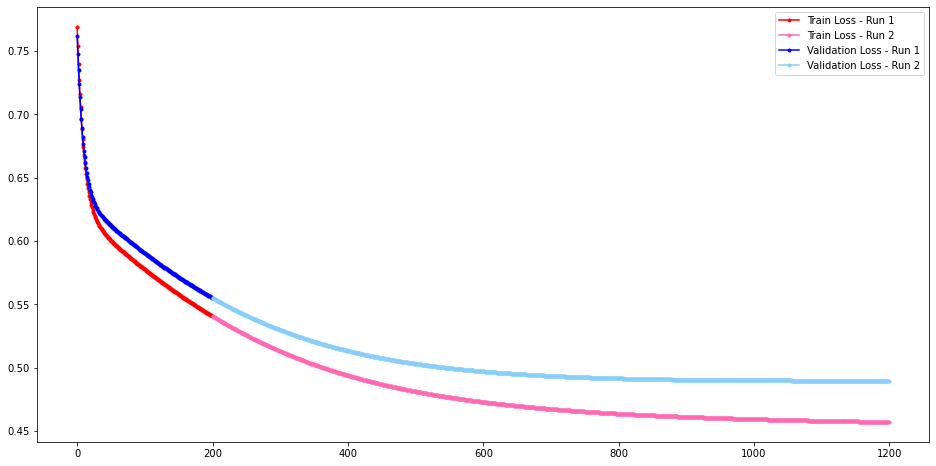

In [37]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

## Exercise 2
For this exercise, do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures

In [38]:
### BEGIN SOLUTION
model_2 = Sequential()
model_2.add(Dense(units=6, input_shape=(8,), activation="relu"))
model_2.add(Dense(units=6, activation="relu"))
model_2.add(Dense(units=1, activation="sigmoid"))


In [39]:
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


In [40]:
model_2.compile(optimizer=SGD(lr = .003),
                loss="binary_crossentropy",
                metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500)

Train on 576 samples, validate on 192 samples
Epoch 1/1500
576/576 [==============================] - 0s 577us/step - loss: 0.9278 - accuracy: 0.4896 - val_loss: 0.9467 - val_accuracy: 0.4948
Epoch 2/1500
576/576 [==============================] - 0s 39us/step - loss: 0.8979 - accuracy: 0.4896 - val_loss: 0.9143 - val_accuracy: 0.5000
Epoch 3/1500
576/576 [==============================] - 0s 42us/step - loss: 0.8721 - accuracy: 0.4896 - val_loss: 0.8859 - val_accuracy: 0.5104
Epoch 4/1500
576/576 [==============================] - 0s 39us/step - loss: 0.8498 - accuracy: 0.4931 - val_loss: 0.8607 - val_accuracy: 0.5104
Epoch 5/1500
576/576 [==============================] - 0s 39us/step - loss: 0.8303 - accuracy: 0.5017 - val_loss: 0.8383 - val_accuracy: 0.5156
Epoch 6/1500
576/576 [==============================] - 0s 38us/step - loss: 0.8133 - accuracy: 0.5156 - val_loss: 0.8187 - val_accuracy: 0.5312
Epoch 7/1500
576/576 [==============================] - 0s 37us/step - loss: 0.7983

Epoch 57/1500
576/576 [==============================] - 0s 41us/step - loss: 0.6087 - accuracy: 0.7083 - val_loss: 0.6046 - val_accuracy: 0.7083
Epoch 58/1500
576/576 [==============================] - 0s 40us/step - loss: 0.6072 - accuracy: 0.7083 - val_loss: 0.6031 - val_accuracy: 0.7083
Epoch 59/1500
576/576 [==============================] - 0s 40us/step - loss: 0.6058 - accuracy: 0.7083 - val_loss: 0.6017 - val_accuracy: 0.7083
Epoch 60/1500
576/576 [==============================] - 0s 40us/step - loss: 0.6043 - accuracy: 0.7083 - val_loss: 0.6003 - val_accuracy: 0.7135
Epoch 61/1500
576/576 [==============================] - 0s 41us/step - loss: 0.6030 - accuracy: 0.7118 - val_loss: 0.5989 - val_accuracy: 0.7083
Epoch 62/1500
576/576 [==============================] - 0s 40us/step - loss: 0.6016 - accuracy: 0.7101 - val_loss: 0.5975 - val_accuracy: 0.7135
Epoch 63/1500
576/576 [==============================] - 0s 41us/step - loss: 0.6002 - accuracy: 0.7101 - val_loss: 0.5961 -

576/576 [==============================] - 0s 39us/step - loss: 0.5531 - accuracy: 0.7274 - val_loss: 0.5517 - val_accuracy: 0.7188
Epoch 114/1500
576/576 [==============================] - 0s 40us/step - loss: 0.5524 - accuracy: 0.7274 - val_loss: 0.5511 - val_accuracy: 0.7240
Epoch 115/1500
576/576 [==============================] - 0s 39us/step - loss: 0.5518 - accuracy: 0.7292 - val_loss: 0.5506 - val_accuracy: 0.7188
Epoch 116/1500
576/576 [==============================] - 0s 39us/step - loss: 0.5511 - accuracy: 0.7292 - val_loss: 0.5500 - val_accuracy: 0.7188
Epoch 117/1500
576/576 [==============================] - 0s 39us/step - loss: 0.5505 - accuracy: 0.7292 - val_loss: 0.5495 - val_accuracy: 0.7188
Epoch 118/1500
576/576 [==============================] - 0s 42us/step - loss: 0.5499 - accuracy: 0.7292 - val_loss: 0.5490 - val_accuracy: 0.7188
Epoch 119/1500
576/576 [==============================] - 0s 42us/step - loss: 0.5492 - accuracy: 0.7292 - val_loss: 0.5485 - val_acc

Epoch 169/1500
576/576 [==============================] - 0s 42us/step - loss: 0.5235 - accuracy: 0.7483 - val_loss: 0.5316 - val_accuracy: 0.7188
Epoch 170/1500
576/576 [==============================] - 0s 41us/step - loss: 0.5231 - accuracy: 0.7483 - val_loss: 0.5314 - val_accuracy: 0.7188
Epoch 171/1500
576/576 [==============================] - 0s 40us/step - loss: 0.5226 - accuracy: 0.7483 - val_loss: 0.5312 - val_accuracy: 0.7188
Epoch 172/1500
576/576 [==============================] - 0s 40us/step - loss: 0.5222 - accuracy: 0.7500 - val_loss: 0.5310 - val_accuracy: 0.7188
Epoch 173/1500
576/576 [==============================] - 0s 40us/step - loss: 0.5218 - accuracy: 0.7483 - val_loss: 0.5308 - val_accuracy: 0.7188
Epoch 174/1500
576/576 [==============================] - 0s 41us/step - loss: 0.5214 - accuracy: 0.7483 - val_loss: 0.5305 - val_accuracy: 0.7240
Epoch 175/1500
576/576 [==============================] - 0s 43us/step - loss: 0.5209 - accuracy: 0.7500 - val_loss: 0

Epoch 225/1500
576/576 [==============================] - 0s 42us/step - loss: 0.5033 - accuracy: 0.7622 - val_loss: 0.5229 - val_accuracy: 0.7396
Epoch 226/1500
576/576 [==============================] - 0s 41us/step - loss: 0.5031 - accuracy: 0.7622 - val_loss: 0.5228 - val_accuracy: 0.7396
Epoch 227/1500
576/576 [==============================] - 0s 41us/step - loss: 0.5028 - accuracy: 0.7622 - val_loss: 0.5227 - val_accuracy: 0.7448
Epoch 228/1500
576/576 [==============================] - 0s 41us/step - loss: 0.5024 - accuracy: 0.7622 - val_loss: 0.5226 - val_accuracy: 0.7448
Epoch 229/1500
576/576 [==============================] - 0s 43us/step - loss: 0.5022 - accuracy: 0.7622 - val_loss: 0.5224 - val_accuracy: 0.7448
Epoch 230/1500
576/576 [==============================] - 0s 41us/step - loss: 0.5019 - accuracy: 0.7622 - val_loss: 0.5223 - val_accuracy: 0.7448
Epoch 231/1500
576/576 [==============================] - 0s 66us/step - loss: 0.5016 - accuracy: 0.7622 - val_loss: 0

Epoch 281/1500
576/576 [==============================] - 0s 45us/step - loss: 0.4892 - accuracy: 0.7639 - val_loss: 0.5172 - val_accuracy: 0.7448
Epoch 282/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4891 - accuracy: 0.7639 - val_loss: 0.5171 - val_accuracy: 0.7448
Epoch 283/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4888 - accuracy: 0.7639 - val_loss: 0.5170 - val_accuracy: 0.7448
Epoch 284/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4887 - accuracy: 0.7639 - val_loss: 0.5169 - val_accuracy: 0.7448
Epoch 285/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4885 - accuracy: 0.7656 - val_loss: 0.5168 - val_accuracy: 0.7448
Epoch 286/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4883 - accuracy: 0.7674 - val_loss: 0.5167 - val_accuracy: 0.7448
Epoch 287/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4881 - accuracy: 0.7656 - val_loss: 0

Epoch 337/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4794 - accuracy: 0.7743 - val_loss: 0.5121 - val_accuracy: 0.7396
Epoch 338/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4792 - accuracy: 0.7708 - val_loss: 0.5120 - val_accuracy: 0.7396
Epoch 339/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4791 - accuracy: 0.7726 - val_loss: 0.5119 - val_accuracy: 0.7396
Epoch 340/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4789 - accuracy: 0.7691 - val_loss: 0.5119 - val_accuracy: 0.7396
Epoch 341/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4787 - accuracy: 0.7708 - val_loss: 0.5118 - val_accuracy: 0.7396
Epoch 342/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4786 - accuracy: 0.7708 - val_loss: 0.5117 - val_accuracy: 0.7396
Epoch 343/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4785 - accuracy: 0.7691 - val_loss: 0

Epoch 393/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4717 - accuracy: 0.7760 - val_loss: 0.5087 - val_accuracy: 0.7396
Epoch 394/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4715 - accuracy: 0.7795 - val_loss: 0.5087 - val_accuracy: 0.7396
Epoch 395/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4714 - accuracy: 0.7760 - val_loss: 0.5087 - val_accuracy: 0.7396
Epoch 396/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4712 - accuracy: 0.7760 - val_loss: 0.5087 - val_accuracy: 0.7396
Epoch 397/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4711 - accuracy: 0.7760 - val_loss: 0.5087 - val_accuracy: 0.7396
Epoch 398/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4710 - accuracy: 0.7760 - val_loss: 0.5087 - val_accuracy: 0.7396
Epoch 399/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4709 - accuracy: 0.7778 - val_loss: 0

Epoch 449/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4654 - accuracy: 0.7743 - val_loss: 0.5070 - val_accuracy: 0.7552
Epoch 450/1500
576/576 [==============================] - 0s 46us/step - loss: 0.4652 - accuracy: 0.7743 - val_loss: 0.5070 - val_accuracy: 0.7552
Epoch 451/1500
576/576 [==============================] - 0s 45us/step - loss: 0.4651 - accuracy: 0.7760 - val_loss: 0.5070 - val_accuracy: 0.7552
Epoch 452/1500
576/576 [==============================] - 0s 47us/step - loss: 0.4651 - accuracy: 0.7743 - val_loss: 0.5070 - val_accuracy: 0.7552
Epoch 453/1500
576/576 [==============================] - 0s 46us/step - loss: 0.4649 - accuracy: 0.7760 - val_loss: 0.5070 - val_accuracy: 0.7552
Epoch 454/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4648 - accuracy: 0.7760 - val_loss: 0.5070 - val_accuracy: 0.7552
Epoch 455/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4647 - accuracy: 0.7760 - val_loss: 0

Epoch 505/1500
576/576 [==============================] - 0s 49us/step - loss: 0.4600 - accuracy: 0.7795 - val_loss: 0.5073 - val_accuracy: 0.7500
Epoch 506/1500
576/576 [==============================] - 0s 53us/step - loss: 0.4599 - accuracy: 0.7795 - val_loss: 0.5073 - val_accuracy: 0.7552
Epoch 507/1500
576/576 [==============================] - 0s 48us/step - loss: 0.4598 - accuracy: 0.7812 - val_loss: 0.5073 - val_accuracy: 0.7552
Epoch 508/1500
576/576 [==============================] - 0s 45us/step - loss: 0.4597 - accuracy: 0.7795 - val_loss: 0.5073 - val_accuracy: 0.7552
Epoch 509/1500
576/576 [==============================] - 0s 47us/step - loss: 0.4597 - accuracy: 0.7795 - val_loss: 0.5072 - val_accuracy: 0.7552
Epoch 510/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4596 - accuracy: 0.7830 - val_loss: 0.5072 - val_accuracy: 0.7552
Epoch 511/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4595 - accuracy: 0.7812 - val_loss: 0

Epoch 561/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4561 - accuracy: 0.7812 - val_loss: 0.5061 - val_accuracy: 0.7500
Epoch 562/1500
576/576 [==============================] - 0s 44us/step - loss: 0.4561 - accuracy: 0.7812 - val_loss: 0.5061 - val_accuracy: 0.7500
Epoch 563/1500
576/576 [==============================] - 0s 47us/step - loss: 0.4559 - accuracy: 0.7812 - val_loss: 0.5061 - val_accuracy: 0.7500
Epoch 564/1500
576/576 [==============================] - 0s 49us/step - loss: 0.4559 - accuracy: 0.7812 - val_loss: 0.5060 - val_accuracy: 0.7500
Epoch 565/1500
576/576 [==============================] - 0s 46us/step - loss: 0.4558 - accuracy: 0.7812 - val_loss: 0.5060 - val_accuracy: 0.7500
Epoch 566/1500
576/576 [==============================] - 0s 47us/step - loss: 0.4558 - accuracy: 0.7812 - val_loss: 0.5060 - val_accuracy: 0.7500
Epoch 567/1500
576/576 [==============================] - 0s 47us/step - loss: 0.4557 - accuracy: 0.7812 - val_loss: 0

Epoch 617/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4520 - accuracy: 0.7778 - val_loss: 0.5044 - val_accuracy: 0.7604
Epoch 618/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4520 - accuracy: 0.7760 - val_loss: 0.5044 - val_accuracy: 0.7604
Epoch 619/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4518 - accuracy: 0.7760 - val_loss: 0.5043 - val_accuracy: 0.7604
Epoch 620/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4518 - accuracy: 0.7795 - val_loss: 0.5043 - val_accuracy: 0.7604
Epoch 621/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4517 - accuracy: 0.7795 - val_loss: 0.5044 - val_accuracy: 0.7604
Epoch 622/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4517 - accuracy: 0.7778 - val_loss: 0.5043 - val_accuracy: 0.7604
Epoch 623/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4516 - accuracy: 0.7795 - val_loss: 0

Epoch 673/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4484 - accuracy: 0.7812 - val_loss: 0.5032 - val_accuracy: 0.7656
Epoch 674/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4484 - accuracy: 0.7812 - val_loss: 0.5032 - val_accuracy: 0.7656
Epoch 675/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4482 - accuracy: 0.7830 - val_loss: 0.5031 - val_accuracy: 0.7656
Epoch 676/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4482 - accuracy: 0.7847 - val_loss: 0.5031 - val_accuracy: 0.7656
Epoch 677/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4482 - accuracy: 0.7847 - val_loss: 0.5030 - val_accuracy: 0.7656
Epoch 678/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4481 - accuracy: 0.7847 - val_loss: 0.5030 - val_accuracy: 0.7656
Epoch 679/1500
576/576 [==============================] - 0s 44us/step - loss: 0.4480 - accuracy: 0.7795 - val_loss: 0

Epoch 729/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4454 - accuracy: 0.7812 - val_loss: 0.5024 - val_accuracy: 0.7656
Epoch 730/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4454 - accuracy: 0.7795 - val_loss: 0.5024 - val_accuracy: 0.7656
Epoch 731/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4454 - accuracy: 0.7795 - val_loss: 0.5024 - val_accuracy: 0.7708
Epoch 732/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4453 - accuracy: 0.7795 - val_loss: 0.5025 - val_accuracy: 0.7708
Epoch 733/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4453 - accuracy: 0.7812 - val_loss: 0.5024 - val_accuracy: 0.7708
Epoch 734/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4452 - accuracy: 0.7795 - val_loss: 0.5025 - val_accuracy: 0.7708
Epoch 735/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4452 - accuracy: 0.7795 - val_loss: 0

Epoch 785/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4429 - accuracy: 0.7812 - val_loss: 0.5022 - val_accuracy: 0.7656
Epoch 786/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4429 - accuracy: 0.7812 - val_loss: 0.5021 - val_accuracy: 0.7656
Epoch 787/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4428 - accuracy: 0.7812 - val_loss: 0.5021 - val_accuracy: 0.7656
Epoch 788/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4427 - accuracy: 0.7812 - val_loss: 0.5021 - val_accuracy: 0.7656
Epoch 789/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4427 - accuracy: 0.7830 - val_loss: 0.5021 - val_accuracy: 0.7656
Epoch 790/1500
576/576 [==============================] - 0s 49us/step - loss: 0.4427 - accuracy: 0.7830 - val_loss: 0.5021 - val_accuracy: 0.7656
Epoch 791/1500
576/576 [==============================] - 0s 49us/step - loss: 0.4427 - accuracy: 0.7812 - val_loss: 0

Epoch 841/1500
576/576 [==============================] - 0s 48us/step - loss: 0.4406 - accuracy: 0.7917 - val_loss: 0.5019 - val_accuracy: 0.7604
Epoch 842/1500
576/576 [==============================] - 0s 51us/step - loss: 0.4406 - accuracy: 0.7899 - val_loss: 0.5019 - val_accuracy: 0.7604
Epoch 843/1500
576/576 [==============================] - 0s 47us/step - loss: 0.4407 - accuracy: 0.7899 - val_loss: 0.5019 - val_accuracy: 0.7604
Epoch 844/1500
576/576 [==============================] - 0s 168us/step - loss: 0.4405 - accuracy: 0.7899 - val_loss: 0.5019 - val_accuracy: 0.7604
Epoch 845/1500
576/576 [==============================] - 0s 79us/step - loss: 0.4406 - accuracy: 0.7917 - val_loss: 0.5019 - val_accuracy: 0.7604
Epoch 846/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4404 - accuracy: 0.7917 - val_loss: 0.5019 - val_accuracy: 0.7604
Epoch 847/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4405 - accuracy: 0.7917 - val_loss: 

Epoch 897/1500
576/576 [==============================] - 0s 45us/step - loss: 0.4386 - accuracy: 0.7917 - val_loss: 0.5025 - val_accuracy: 0.7656
Epoch 898/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4385 - accuracy: 0.7917 - val_loss: 0.5026 - val_accuracy: 0.7656
Epoch 899/1500
576/576 [==============================] - 0s 47us/step - loss: 0.4385 - accuracy: 0.7934 - val_loss: 0.5026 - val_accuracy: 0.7656
Epoch 900/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4385 - accuracy: 0.7917 - val_loss: 0.5026 - val_accuracy: 0.7656
Epoch 901/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4384 - accuracy: 0.7934 - val_loss: 0.5026 - val_accuracy: 0.7656
Epoch 902/1500
576/576 [==============================] - 0s 44us/step - loss: 0.4384 - accuracy: 0.7917 - val_loss: 0.5027 - val_accuracy: 0.7656
Epoch 903/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4384 - accuracy: 0.7917 - val_loss: 0

Epoch 953/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4365 - accuracy: 0.7986 - val_loss: 0.5034 - val_accuracy: 0.7656
Epoch 954/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4365 - accuracy: 0.7969 - val_loss: 0.5034 - val_accuracy: 0.7656
Epoch 955/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4364 - accuracy: 0.7969 - val_loss: 0.5035 - val_accuracy: 0.7604
Epoch 956/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4364 - accuracy: 0.7986 - val_loss: 0.5035 - val_accuracy: 0.7604
Epoch 957/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4364 - accuracy: 0.7969 - val_loss: 0.5035 - val_accuracy: 0.7604
Epoch 958/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4363 - accuracy: 0.7951 - val_loss: 0.5035 - val_accuracy: 0.7604
Epoch 959/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4362 - accuracy: 0.7951 - val_loss: 0

576/576 [==============================] - 0s 40us/step - loss: 0.4345 - accuracy: 0.8021 - val_loss: 0.5039 - val_accuracy: 0.7604
Epoch 1009/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4345 - accuracy: 0.7986 - val_loss: 0.5039 - val_accuracy: 0.7604
Epoch 1010/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4345 - accuracy: 0.8021 - val_loss: 0.5039 - val_accuracy: 0.7604
Epoch 1011/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4344 - accuracy: 0.8021 - val_loss: 0.5039 - val_accuracy: 0.7604
Epoch 1012/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4344 - accuracy: 0.8003 - val_loss: 0.5039 - val_accuracy: 0.7604
Epoch 1013/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4343 - accuracy: 0.8021 - val_loss: 0.5038 - val_accuracy: 0.7604
Epoch 1014/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4342 - accuracy: 0.8003 - val_loss: 0.5039 - v

576/576 [==============================] - 0s 40us/step - loss: 0.4326 - accuracy: 0.8056 - val_loss: 0.5041 - val_accuracy: 0.7552
Epoch 1064/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4327 - accuracy: 0.8056 - val_loss: 0.5040 - val_accuracy: 0.7552
Epoch 1065/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4326 - accuracy: 0.8073 - val_loss: 0.5040 - val_accuracy: 0.7552
Epoch 1066/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4326 - accuracy: 0.8056 - val_loss: 0.5041 - val_accuracy: 0.7552
Epoch 1067/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4325 - accuracy: 0.8056 - val_loss: 0.5041 - val_accuracy: 0.7552
Epoch 1068/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4325 - accuracy: 0.8056 - val_loss: 0.5041 - val_accuracy: 0.7552
Epoch 1069/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4326 - accuracy: 0.8073 - val_loss: 0.5041 - v

576/576 [==============================] - 0s 42us/step - loss: 0.4313 - accuracy: 0.8073 - val_loss: 0.5045 - val_accuracy: 0.7552
Epoch 1119/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4312 - accuracy: 0.8073 - val_loss: 0.5045 - val_accuracy: 0.7552
Epoch 1120/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4312 - accuracy: 0.8056 - val_loss: 0.5045 - val_accuracy: 0.7552
Epoch 1121/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4311 - accuracy: 0.8038 - val_loss: 0.5045 - val_accuracy: 0.7552
Epoch 1122/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4311 - accuracy: 0.8073 - val_loss: 0.5045 - val_accuracy: 0.7552
Epoch 1123/1500
576/576 [==============================] - 0s 46us/step - loss: 0.4311 - accuracy: 0.8056 - val_loss: 0.5044 - val_accuracy: 0.7552
Epoch 1124/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4311 - accuracy: 0.8056 - val_loss: 0.5044 - v

576/576 [==============================] - 0s 40us/step - loss: 0.4300 - accuracy: 0.8090 - val_loss: 0.5045 - val_accuracy: 0.7552
Epoch 1174/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4299 - accuracy: 0.8090 - val_loss: 0.5044 - val_accuracy: 0.7552
Epoch 1175/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4300 - accuracy: 0.8090 - val_loss: 0.5044 - val_accuracy: 0.7552
Epoch 1176/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4300 - accuracy: 0.8073 - val_loss: 0.5044 - val_accuracy: 0.7552
Epoch 1177/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4299 - accuracy: 0.8073 - val_loss: 0.5044 - val_accuracy: 0.7552
Epoch 1178/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4299 - accuracy: 0.8090 - val_loss: 0.5044 - val_accuracy: 0.7552
Epoch 1179/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4299 - accuracy: 0.8108 - val_loss: 0.5044 - v

576/576 [==============================] - 0s 43us/step - loss: 0.4288 - accuracy: 0.8073 - val_loss: 0.5043 - val_accuracy: 0.7552
Epoch 1229/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4288 - accuracy: 0.8073 - val_loss: 0.5043 - val_accuracy: 0.7552
Epoch 1230/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4288 - accuracy: 0.8073 - val_loss: 0.5043 - val_accuracy: 0.7552
Epoch 1231/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4289 - accuracy: 0.8073 - val_loss: 0.5043 - val_accuracy: 0.7552
Epoch 1232/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4287 - accuracy: 0.8056 - val_loss: 0.5043 - val_accuracy: 0.7552
Epoch 1233/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4287 - accuracy: 0.8056 - val_loss: 0.5043 - val_accuracy: 0.7552
Epoch 1234/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4287 - accuracy: 0.8073 - val_loss: 0.5043 - v

576/576 [==============================] - 0s 39us/step - loss: 0.4278 - accuracy: 0.8038 - val_loss: 0.5044 - val_accuracy: 0.7604
Epoch 1284/1500
576/576 [==============================] - 0s 44us/step - loss: 0.4277 - accuracy: 0.8038 - val_loss: 0.5044 - val_accuracy: 0.7604
Epoch 1285/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4278 - accuracy: 0.8038 - val_loss: 0.5044 - val_accuracy: 0.7604
Epoch 1286/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4279 - accuracy: 0.8038 - val_loss: 0.5044 - val_accuracy: 0.7604
Epoch 1287/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4278 - accuracy: 0.8056 - val_loss: 0.5044 - val_accuracy: 0.7604
Epoch 1288/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4277 - accuracy: 0.8056 - val_loss: 0.5045 - val_accuracy: 0.7604
Epoch 1289/1500
576/576 [==============================] - 0s 44us/step - loss: 0.4277 - accuracy: 0.8021 - val_loss: 0.5045 - v

576/576 [==============================] - 0s 40us/step - loss: 0.4268 - accuracy: 0.8021 - val_loss: 0.5046 - val_accuracy: 0.7552
Epoch 1339/1500
576/576 [==============================] - 0s 41us/step - loss: 0.4267 - accuracy: 0.8038 - val_loss: 0.5046 - val_accuracy: 0.7552
Epoch 1340/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4267 - accuracy: 0.8021 - val_loss: 0.5047 - val_accuracy: 0.7552
Epoch 1341/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4267 - accuracy: 0.8038 - val_loss: 0.5047 - val_accuracy: 0.7552
Epoch 1342/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4266 - accuracy: 0.8021 - val_loss: 0.5047 - val_accuracy: 0.7552
Epoch 1343/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4266 - accuracy: 0.8021 - val_loss: 0.5046 - val_accuracy: 0.7552
Epoch 1344/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4266 - accuracy: 0.8003 - val_loss: 0.5046 - v

576/576 [==============================] - 0s 38us/step - loss: 0.4256 - accuracy: 0.8021 - val_loss: 0.5047 - val_accuracy: 0.7604
Epoch 1394/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4256 - accuracy: 0.8021 - val_loss: 0.5048 - val_accuracy: 0.7604
Epoch 1395/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4255 - accuracy: 0.8038 - val_loss: 0.5047 - val_accuracy: 0.7604
Epoch 1396/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4255 - accuracy: 0.8021 - val_loss: 0.5048 - val_accuracy: 0.7604
Epoch 1397/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4255 - accuracy: 0.8003 - val_loss: 0.5048 - val_accuracy: 0.7604
Epoch 1398/1500
576/576 [==============================] - 0s 44us/step - loss: 0.4254 - accuracy: 0.8003 - val_loss: 0.5048 - val_accuracy: 0.7604
Epoch 1399/1500
576/576 [==============================] - 0s 47us/step - loss: 0.4254 - accuracy: 0.8003 - val_loss: 0.5049 - v

576/576 [==============================] - 0s 47us/step - loss: 0.4244 - accuracy: 0.8021 - val_loss: 0.5050 - val_accuracy: 0.7604
Epoch 1449/1500
576/576 [==============================] - 0s 45us/step - loss: 0.4244 - accuracy: 0.8038 - val_loss: 0.5050 - val_accuracy: 0.7604
Epoch 1450/1500
576/576 [==============================] - 0s 54us/step - loss: 0.4244 - accuracy: 0.8003 - val_loss: 0.5051 - val_accuracy: 0.7604
Epoch 1451/1500
576/576 [==============================] - 0s 57us/step - loss: 0.4243 - accuracy: 0.8038 - val_loss: 0.5051 - val_accuracy: 0.7604
Epoch 1452/1500
576/576 [==============================] - 0s 44us/step - loss: 0.4242 - accuracy: 0.8021 - val_loss: 0.5051 - val_accuracy: 0.7604
Epoch 1453/1500
576/576 [==============================] - 0s 46us/step - loss: 0.4242 - accuracy: 0.8038 - val_loss: 0.5051 - val_accuracy: 0.7604
Epoch 1454/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4242 - accuracy: 0.8056 - val_loss: 0.5051 - v

In [41]:
run_hist_2.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

Text(0.5, 1.0, 'Accuracy over iterations')

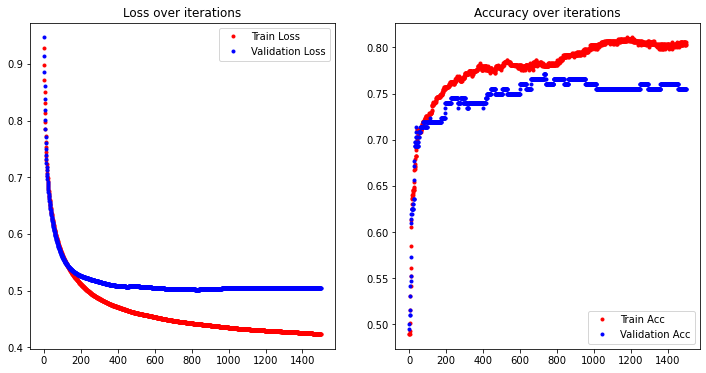

In [42]:
n = len(run_hist_2.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_2.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_2.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_2.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_2.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')


accuracy is 0.755
roc-auc is 0.817


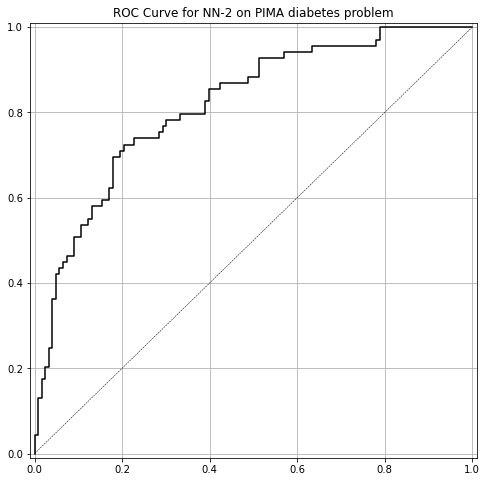

In [43]:
y_pred_class_nn_2 = model_2.predict_classes(X_test_norm)
y_pred_prob_nn_2 = model_2.predict(X_test_norm)
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN-2')
### END SOLUTION

---
### Machine Learning Foundation (C) 2020 IBM Corporation